This is a demo of local variation coarsening methods from the paper: 
* Andreas Loukas, [Graph reduction by local variation](https://arxiv.org/abs/1808.10650), preprint 2018

See also
* Andreas Loukas and Pierre Vandergheynst, [Spectrally Approximating Large Graphs with Smaller Graphs](http://proceedings.mlr.press/v80/loukas18a/loukas18a.pdf), International Conference on Machine Learning, 2018

Please cite the aforementioned works if you use this code.

Depedencies: pygsp, matplotlib, numpy, scipy, networkx, sortedcontainers

21 September 2018

Andreas Loukas

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from libraries.coarsening_utils import *
import libraries.graph_utils as graph_utils

import os
import numpy as np
import scipy as sp
from scipy.io import loadmat

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx
import pygsp as gsp
from pygsp import graphs
gsp.plotting.BACKEND = 'matplotlib'

### Construct the graph ### 

Choose one of the following

wiki graph

In [4]:
mat = loadmat('POS.mat')
matrix = mat['network']
cx = matrix.tocoo()
edgelist = zip(cx.row, cx.col)
G = nx.Graph()
G.add_edges_from(edgelist)
print(G.number_of_nodes())
print(G.number_of_edges())
W = nx.adjacency_matrix(G).toarray()
np.fill_diagonal(W, 0)
W = sp.sparse.csr_matrix(W)
G = graphs.Graph(W)
N = G.N

4777
92517


Let's compute some useful things about our graph

In [5]:
if not hasattr(G, 'coords'): 
    graph = nx.from_scipy_sparse_matrix(G.W)
    pos = nx.nx_agraph.pygraphviz_layout(graph, prog='neato') # ['neato'|'dot'|'twopi'|'circo'|'fdp'|'nop']
    G.set_coordinates(np.array(list(pos.values())))   
    #G.set_coordinates(kind='spring', dim=3)  


In [7]:
e, U = np.linalg.eigh(G.L.toarray())
print(e[:5])

[-9.18817974e-12  1.96794968e+00  1.99966996e+00  3.24785064e+00
  3.54055053e+00]


In [27]:
print(e[0] > -1e-11)

True


In [6]:
G.compute_fourier_basis(recompute=True) 
L = G.L.toarray()
S = get_S(G).T

print(f'The graph has {N} nodes.')

2022-01-14 21:22:23,566:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4777 x 4777) may take some time.


The graph has 4777 nodes.


## On to coarsening!

* Possible methods supported are: 
    * 'variation_edges', 
    * 'variation_neighborhood', 
    * 'heavy_edge
* $r = 1 - n/N$ is the dimensionality reduction ratio
* $k$ is the size of the subspace we are interested in
* $k_{max}$ should be set to be larger or equal to $k$. It allows us to measure the quality of coarsening over subspaces larger than $k$.

In [12]:
method = 'variation_edges'  
Kout = 2000
# Parameters
r    = 1-Kout/N# the extend of dimensionality reduction (r=0 means no reduction)
k    = 10  
kmax = int(8*k)
print("red", r)
C, Gc, Call, Gall = coarsen(G, K=kmax, r=r, method=method, max_levels=1000) 
print("done")

print('{:16} | r: {:1.4}, nedges: {}, levels: {}, epsilon: {:1.4}'.format(method, len(Call)))
#print('{:16} | r: {:1.4}, nedges: {}, levels: {}, epsilon: {:1.4}'.format(method, metrics['r'], metrics['m'], len(Call), metrics['error_subspace'][k-1]))

red 0.5813271927988277
mjz, level 1
mjz 1 2659 2000.0 0.5813271927988277
mjz, level 2
mjz 2 2000 2000.0 0.24783753290710797
done


NameError: name 'metrics' is not defined

In [13]:
Gc.W.shape
np.save("Gc_"+str(Kout)+".npy", Gc.W.toarray())

In [ ]:
metrics = coarsening_quality(G, C, kmax=kmax)
n = Gc.N

### Visualize the sequence of coarsening levels

* $c+1$ graphs are plotted in total. The leftmost is the original graph and the rightmost is the final coarse graph. 
* Colors are used to indicate the size of each contraction set $C$: 
    * green is for $|C|=2$  blue is for $|C|=3$, red is for $|C|=4$, and yellow for $|C|>4$


In [11]:
fig = plot_coarsening(Gall, Call, size=5, alpha=0.6, title=method, smooth=0.4);

fig.savefig(fname='wiki.png', dpi=250)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f35fdfc89d0> (for post_execute):


KeyboardInterrupt: 

### Various metrics for coarsening quality

* $\epsilon$ is the restricted similarity constant such that, for every $x \in span(U_k)$ we have $$(1 - \epsilon) x^\top L x \leq x_c^\top L_c x_c \leq (1+\epsilon) x^\top L x $$   
* the eigenvalue error is defined (for every $i = 1, \ldots, k, \ldots, kmax$ as $\frac{\lambda_i - \tilde{\lambda}_i}{\lambda_i}$
* the angle matrix contains the angles between the eigenvectors of $L$ (y-axis) and the lifted eigenvectors of $L_c$. The closer to counter-diagonal it is, the better.

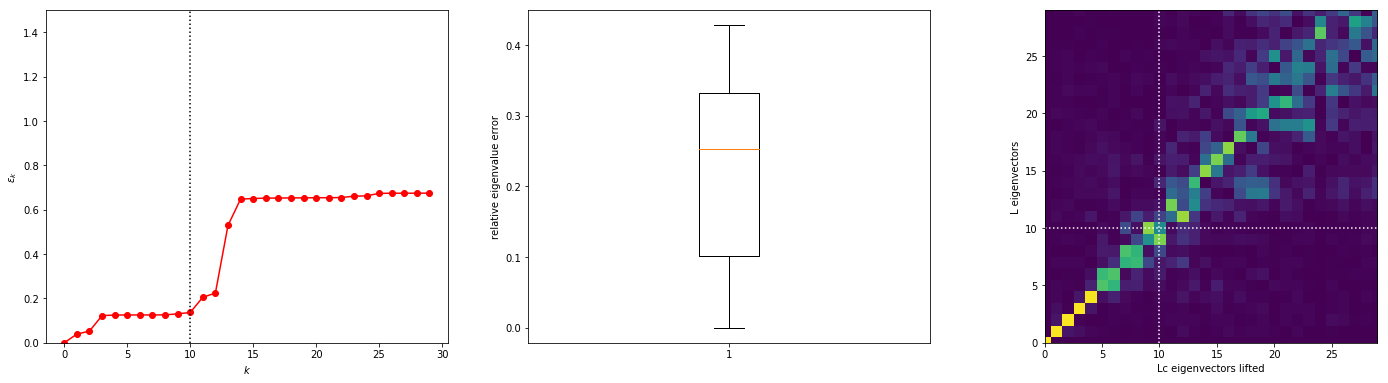

In [108]:
size = 2.04; fig, axes = plt.subplots(1, 3, figsize=(4*size*3, 3*size)); linewidth = 1

axes[0].plot(np.arange(kmax), np.abs(metrics['error_subspace']), 'or-') 
axes[0].set_xlabel('$k$'); axes[0].set_ylabel('$\epsilon_k$')
axes[0].plot( [k, k], [0, max(1.5, max(metrics['error_subspace']))], ':k') 
axes[0].set_ylim([0, 1.5])

axes[1].boxplot(np.abs(metrics['error_eigenvalue'])) 
axes[1].set_ylabel('relative eigenvalue error')

axes[2].imshow(abs(metrics['angle_matrix'][:,0:kmax]) )
axes[2].plot( [k, k], [0, kmax], ':w') 
axes[2].plot( [0, kmax], [k, k], ':w') 
axes[2].plot( [0, N], [n-1, n-1], ':w') 
axes[2].set_xlim([0, kmax-1])
axes[2].set_ylim([0, kmax-1])
axes[2].set_xlabel('Lc eigenvectors lifted'); axes[2].set_ylabel('L eigenvectors');
# fig.savefig('quantitative_yeast.png', dpi=250)

### Coarsen and lift a smooth (k-bandlimitted) signal

signal error: 0.04549463697076103


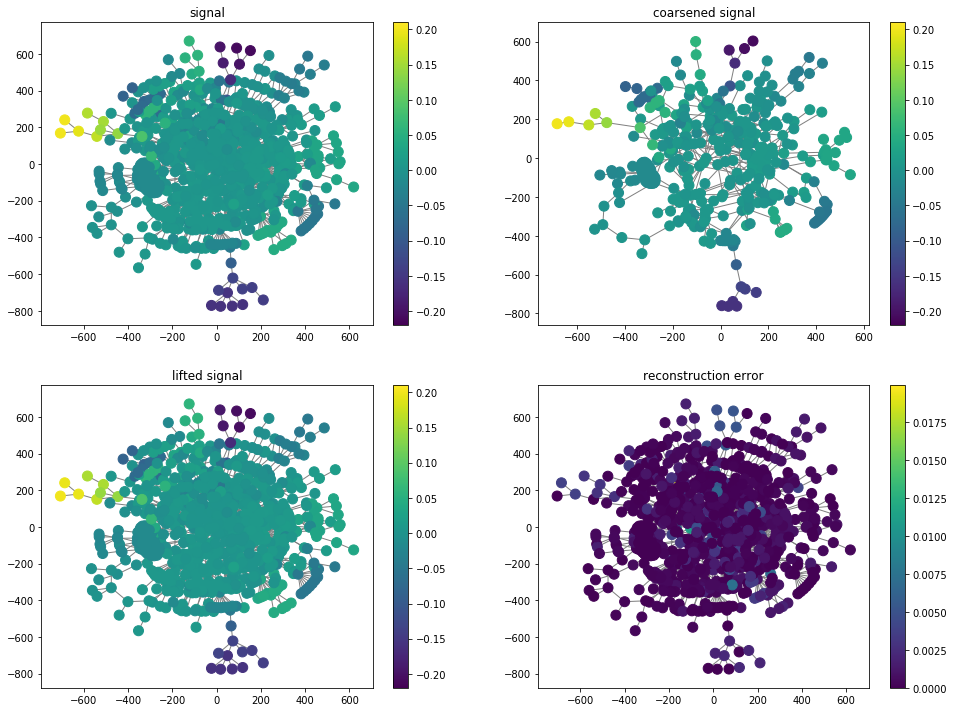

In [109]:
size = 2.04; fig, axes = plt.subplots(2, 2, figsize=(2*size*4, 2*3*size)); linewidth = 1

# a random smooth signal 
x = G.U[:,:k] @ np.random.randn(k,1)
x = x / np.linalg.norm(x)
G.plot_signal(x, ax=axes[0][0], title='signal')

# coarsen it 
xc = coarsen_vector(x, C)
Gc.plot_signal(xc, ax=axes[0][1], title='coarsened signal')

# lift it 
xp = lift_vector(xc, C)
G.plot_signal(xp, ax=axes[1][0], title='lifted signal')

# difference
G.plot_signal(np.abs(x-xp), ax=axes[1][1], title='reconstruction error')

print('signal error: {}'.format(np.linalg.norm(x - xp)))

# fig.savefig('signal_yeast.png', dpi=250)